# Jobs.ch - Web Scraping - Analysis (PENDING)

In [1]:
from bs4 import BeautifulSoup
from datetime import date
import pandas as pd
import re
import requests
import seaborn as sns
import time

# Analysis

In [2]:
# Number of jobs per search
title_num_jobs = jobs_ch_df.groupby("job_search").agg(num_jobs = ("job_id", "nunique")).sort_values("num_jobs", ascending=False).head(10)
title_num_jobs.reset_index()

NameError: name 'jobs_ch_df' is not defined

In [ ]:
snstitle_num_jobs

In [42]:
# Overlap between roles

dif_jobs = jobs_ch_df[["job_id", "job_search"]]
dif_jobs

dif_jobs_merged = pd.merge(dif_jobs, dif_jobs, on="job_id")
dif_jobs_merged["delete"] = dif_jobs_merged["job_search_x"] == dif_jobs_merged["job_search_y"]
dif_jobs_merged = dif_jobs_merged[dif_jobs_merged["delete"] == False].reset_index(drop=True)
dif_jobs_merged = dif_jobs_merged.groupby(["job_search_x", "job_search_y"]).agg(num_jobs = ("job_id", "count")).reset_index()
dif_jobs_merged

,job_search_x,job_search_y,num_jobs
0,Big Data Analyst,Data Analyst,4
1,Big Data Analyst,Data Engineer,2
2,Big Data Analyst,Data Scientist,3
3,Big Data Analyst,Machine Learning Engineer,2
4,Data Analyst,Big Data Analyst,4
5,Data Analyst,Data Architect,2
6,Data Analyst,Data Engineer,5
7,Data Analyst,Data Scientist,4
8,Data Analyst,Machine Learning Engineer,1
9,Data Architect,Data Analyst,2


In [72]:
import pandas as pd
import plotly
import plotly.plotly as py

import plotly.graph_objects as go


In [56]:
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):

    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig


fig = genSankey(dif_jobs_merged,cat_cols=["job_search_x", "job_search_y"],value_cols='num_jobs',title='Sankey Diagram')

plotly.offline.plot(fig, validate=False)


AttributeError: module 'plotly' has no attribute 'plot'

In [73]:
label = ["Data Scientist", "Data Analyst", "Data Engineer", "Machine Learning Engineer", "Big Data Analyst", "Data Architect"]

label_df = pd.DataFrame(label)
label_dict = label_df.to_dict()[0]
label_dict

source = [0,0,0,0,1,1,1,1,2,2,3,3,3,3,3,4,4,4,4,5,5,5,5]
value = dif_jobs_merged["num_jobs"]
target = [0,1,2,3,0,2,5,4,1,2,4,3,4,2,1,1,1,2,1,5,5,4,1]

link = dict(source=source, target=target, value=value)
node = dict(label=label, pad=35, thickness=10)
data = go.Sankey(link=link, node=node)
    


AttributeError: module 'plotly.graph_objects' has no attribute 'Sankey'

# Text Analysis

In [7]:
import nltk
from nltk.corpus import stopwords

In [8]:
# Drop duplicates based on the job_id (different searches can have same results)
jobs_df = jobs_ch_df.drop_duplicates("job_id")

# Check number of jobs scanned with no description
no_des_perc = len(jobs_df[jobs_df["job_description"] == ""]) / len(jobs_df) * 100
num_jobs = len(jobs_df["job_id"].unique())

print("Total number of unique jobs scrapped:", num_jobs)
print("Number of jobs without description scrapped: {}%".format(no_des_perc))

Total number of unique jobs scrapped: 77
Number of jobs without description scrapped: 3.896103896103896%


In [9]:
jobs_df["job_description"][0:3]

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

We can see in the descriptions printed above that there are a lot of characters that we do not need like "\n" and "\xa0".
Let's proceed to remove it.

In [10]:
# Apply the replace function to each of the rows

def my_replace(sentence: str, remove_char: list):
    for char in remove_char:
        sentence = sentence.replace(char, "")
    return sentence

replace_char = ["\n","\xa0", "/", "|", ":", ".", "•", "#", "(", ")", ",", "-", "%", "&"]
        
# List comprehensions
job_descriptions = []
[job_descriptions.append(my_replace(value, replace_char)) for value in jobs_df["job_description"]]
job_descriptions[0:3]


['',
 'Data Scientist  Visualization Business Analyst  Click here to login or register  Search For more jobs  Forward this job to a friend  APPLY by email without registration  APPLY by creating  using an account Reference    2000017 Title   Data Scientist  Visualization Business Analyst Location    Switzerland  Position Type   ContractTemporär Experience Level   6 Years Start Date  End Date   01022021  31122020   Description  General information Start date ASAPEnd date 31122021 an extension is possibleWork load 80  100Work location Basel and remote  Main tasks  Aggregate and create simple but powerful data representations from distributed data sources Prioritize often conflicting requirements in close collaboration with key business stakeholders  Collaborate closely with the project delivery team to establish epics user stories acceptance criteria and detailed specifications  Contribute to development sprints by explaining and detailing requirements to the delivery team and by reviewi

In [11]:
# Unique element in a list
all_des = ''.join([description for description in job_descriptions])
all_des[0:1000]

'Data Scientist  Visualization Business Analyst  Click here to login or register  Search For more jobs  Forward this job to a friend  APPLY by email without registration  APPLY by creating  using an account Reference    2000017 Title   Data Scientist  Visualization Business Analyst Location    Switzerland  Position Type   ContractTemporär Experience Level   6 Years Start Date  End Date   01022021  31122020   Description  General information Start date ASAPEnd date 31122021 an extension is possibleWork load 80  100Work location Basel and remote  Main tasks  Aggregate and create simple but powerful data representations from distributed data sources Prioritize often conflicting requirements in close collaboration with key business stakeholders  Collaborate closely with the project delivery team to establish epics user stories acceptance criteria and detailed specifications  Contribute to development sprints by explaining and detailing requirements to the delivery team and by reviewing and

#### Word Tokenization
Word tokenizer breaks text paragraph into words.

In [12]:
from nltk.tokenize import word_tokenize

tokenized_word = word_tokenize(all_des)
tokenized_word[0:10]

['Data',
 'Scientist',
 'Visualization',
 'Business',
 'Analyst',
 'Click',
 'here',
 'to',
 'login',
 'or']

#### Frequency Distribution


In [13]:
from nltk.probability import FreqDist

fdist = FreqDist(tokenized_word)
print(fdist)

fdist.most_common(25)

<FreqDist with 5966 samples and 51317 outcomes>


[('and', 2750),
 ('to', 1410),
 ('the', 1385),
 ('of', 1126),
 ('in', 939),
 ('a', 729),
 ('with', 678),
 ('for', 563),
 ('you', 381),
 ('is', 373),
 ('our', 360),
 ('or', 316),
 ('as', 300),
 ('are', 287),
 ('on', 269),
 ('team', 263),
 ('data', 251),
 ('will', 237),
 ('work', 215),
 ('experience', 208),
 ('business', 201),
 ('skills', 187),
 ('we', 187),
 ('that', 187),
 ('We', 183)]

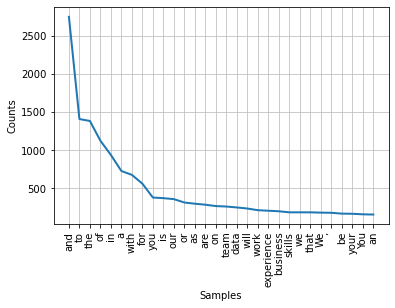

In [14]:
# Frequency Distribution Plot
import matplotlib.pyplot as plt

fdist.plot(30,cumulative=False)
plt.show()

As we see above, the most common words does not have any meaning. Let's proceed to remove the characters ":", "/", "|" and the stop words.

#### Stopwords

Stopwords considered as noise in the text. Text may contain stop words such as is, am, are, this, a, an, the, etc.

In [15]:
from nltk.corpus import stopwords
# nltk.download('stopwords')

# Load stop words
stop_words_en = stopwords.words('english')

# There are some descriptions in german and in french
stop_words_ger = stopwords.words('german')
stop_words_fr = stopwords.words('french')  

stop_words = stop_words_en + stop_words_ger + stop_words_fr

filtered_sent=[]

for w in tokenized_word:
    if w not in stop_words:
        filtered_sent.append(w)

print("Filterd sentence:",filtered_sent[0:100])


Filterd sentence: ['Data', 'Scientist', 'Visualization', 'Business', 'Analyst', 'Click', 'login', 'register', 'Search', 'For', 'jobs', 'Forward', 'job', 'friend', 'APPLY', 'email', 'without', 'registration', 'APPLY', 'creating', 'using', 'account', 'Reference', '2000017', 'Title', 'Data', 'Scientist', 'Visualization', 'Business', 'Analyst', 'Location', 'Switzerland', 'Position', 'Type', 'ContractTemporär', 'Experience', 'Level', '6', 'Years', 'Start', 'Date', 'End', 'Date', '01022021', '31122020', 'Description', 'General', 'information', 'Start', 'date', 'ASAPEnd', 'date', '31122021', 'extension', 'possibleWork', 'load', '80', '100Work', 'location', 'Basel', 'remote', 'Main', 'tasks', 'Aggregate', 'create', 'simple', 'powerful', 'data', 'representations', 'distributed', 'data', 'sources', 'Prioritize', 'often', 'conflicting', 'requirements', 'close', 'collaboration', 'key', 'business', 'stakeholders', 'Collaborate', 'closely', 'project', 'delivery', 'team', 'establish', 'epics', 'user'

<FreqDist with 5804 samples and 35030 outcomes>


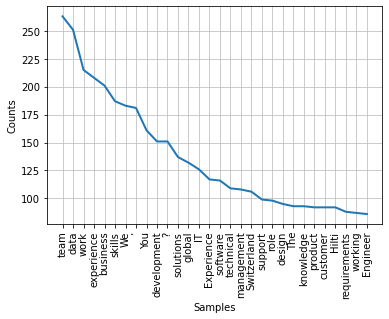

In [74]:
fdist = FreqDist(filtered_sent)
print(fdist)

fdist.most_common(2)

fdist.plot(30,cumulative=False)
plt.show()

#### Lexicon Normalization
Lexicon normalization considers another type of noise in the text. For example, connection, connected, connecting word reduce to a common word "connect". It reduces derivationally related forms of a word to a common root word.

#### Word cloud

References:
* https://www.section.io/engineering-education/word-cloud/
* https://www.datacamp.com/community/tutorials/wordcloud-python

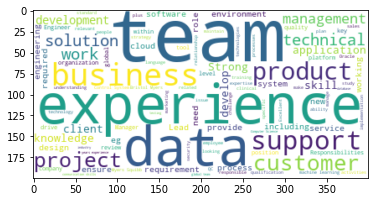

In [75]:
from wordcloud import WordCloud, ImageColorGenerator


text = (" ").join(filtered_sent)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# TESTS

In [ ]:
# Let's see what data we can scrape from each job description

# Empresa sin link
url = "https://www.jobs.ch/en/vacancies/?location=Switzerland&term=Data%20Analyst&jobid=000006126777f45d398814ec2a5baf782c066b2373"
# soup.find("div", {"class": "sc-dkPtyc DetailVacancyTextHtmlComponent___StyledDiv-sc-1b688f6-0 bUboxJ gskOiI"}).get_text()

# Empresa con link
#url = "https://www.jobs.ch/en/vacancies/?location=Switzerland&term=Data%20Analyst&jobid=0000453836b4933444e838001bcc87df91db8d05a7"
# soup.find("div", {"class": "sc-dkPtyc DetailVacancyTextHtmlComponent___StyledDiv-sc-1b688f6-0 bUboxJ gskOiI"}).get_text()

#url = "https://www.jobs.ch/en/vacancies/?location=Switzerland&term=Data%20Analyst&jobid=000005779675e0d8c653ea7377eb3a4c55234c6a43"
page = requests.get(url, timeout=1)
soup = BeautifulSoup(page.content, "html.parser")

In [ ]:
def extr_job_desc(soup):
    try:
        job_desc = soup.find("div", {"class": "sc-dkPtyc DetailVacancyTextHtmlComponent___StyledDiv-sc-1b688f6-0 bUboxJ gskOiI"})
    except:
        job_desc = ""
    
    return job_desc

In [ ]:
soup.find("div", {"class": "sc-dkPtyc DetailVacancyTextHtmlComponent___StyledDiv-sc-1b688f6-0 bUboxJ gskOiI"}).findAll("p")